# The Simpsons classification

## Requirements

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
from torchvision.datasets import ImageFolder
#import torchinfo
from torchmetrics import F1Score
import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameters and constants

In [4]:
lr = 0.001
batch_size = 128
epochs = 15

class_number = 42
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class_names = ['abraham_grampa_simpson',
            'agnes_skinner',
            'apu_nahasapeemapetilon',
            'barney_gumble',
            'bart_simpson',
            'carl_carlson',
            'charles_montgomery_burns',
            'chief_wiggum',
            'cletus_spuckler',
            'comic_book_guy',
            'disco_stu',
            'edna_krabappel',
            'fat_tony',
            'gil',
            'groundskeeper_willie',
            'homer_simpson',
            'kent_brockman',
            'krusty_the_clown',
            'lenny_leonard',
            'lionel_hutz',
            'lisa_simpson',
            'maggie_simpson',
            'marge_simpson',
            'martin_prince',
            'mayor_quimby',
            'milhouse_van_houten',
            'miss_hoover',
            'moe_szyslak',
            'ned_flanders',
            'nelson_muntz',
            'otto_mann',
            'patty_bouvier',
            'principal_skinner',
            'professor_john_frink',
            'rainier_wolfcastle',
            'ralph_wiggum',
            'selma_bouvier',
            'sideshow_bob',
            'sideshow_mel',
            'snake_jailbird',
            'troy_mcclure',
            'waylon_smithers']

## NN model

In [5]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 42)

        
        self.train_losses = []
        self.valid_losses = []
        self.test_accs = []
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = self.pool(output)
        output = output.view(-1, 512)
        output = self.fc1(output)
        return output

    def saveModel(self, filename='./simpsons_model.pth'):
        torch.save(obj=self.state_dict(), f=filename)

    def train(self, optimizer, train_loader, criterion, epochs):
        print('Training started')
        steps_number = len(train_loader)
        
        for epoch in range(epochs):
            running_loss = 0.0
            for step, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if step % 23 == 22:    # print every 23 mini-batches
                    print(f'[{epoch + 1}, {step + 1:5d}] loss: {loss.item():.3f}')
            self.train_losses.append(running_loss/steps_number)
            
        print('Training finished')

    def valid(self):
        print('Validation started')
        print('Validation finished')
        pass

    def test(self, test_loader):
        print('Testing started')
        dataiter = iter(test_loader)
        images, labels = next(dataiter)

        avg_f1 = F1Score(task="multiclass", num_classes=42).to(device)
        class_f1 =F1Score(task="multiclass", num_classes=42,average=None).to(device)
        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                
                outputs = self(images)

                _, predicted = torch.max(outputs.data, 1)
                   
                avg_f1.update(predicted,labels)
                class_f1.update(predicted,labels)
                
        self.test_accs = class_f1.compute()        
        print('Testing finished')     
        print(f"F1(torchmetrics): {avg_f1.compute():.3%}")
        

## Optimizer and Loss function

In [6]:
model = Network()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

## Data dividing

In [7]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
                                                torchvision.transforms.Resize((32,32))])
dataset = ImageFolder(
    "../input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset", transform=transform)

train_set, test_set = random_split(dataset, [0.7, 0.3])
#valid_set = ImageFolder ("The Simpsons Characters Data\\valid",transform=transform)

train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=True, num_workers=2)
#valid_loader = torch.utils.data.DataLoader(valid_set,batch_size=batch_size,shuffle=True, num_workers=1)

## Training

In [8]:
model.train(optimizer,train_loader,criterion,epochs)

Training started
[1,    23] loss: 3.391
[1,    46] loss: 3.165
[1,    69] loss: 2.966
[1,    92] loss: 3.000
[1,   115] loss: 2.771
[2,    23] loss: 2.657
[2,    46] loss: 2.676
[2,    69] loss: 2.540
[2,    92] loss: 2.595
[2,   115] loss: 2.641
[3,    23] loss: 2.367
[3,    46] loss: 2.192
[3,    69] loss: 2.360
[3,    92] loss: 2.418
[3,   115] loss: 2.061
[4,    23] loss: 2.105
[4,    46] loss: 2.092
[4,    69] loss: 2.060
[4,    92] loss: 1.974
[4,   115] loss: 1.902
[5,    23] loss: 1.891
[5,    46] loss: 1.914
[5,    69] loss: 1.906
[5,    92] loss: 1.691
[5,   115] loss: 1.737
[6,    23] loss: 1.690
[6,    46] loss: 1.514
[6,    69] loss: 1.495
[6,    92] loss: 1.454
[6,   115] loss: 1.362
[7,    23] loss: 1.503
[7,    46] loss: 1.209
[7,    69] loss: 1.274
[7,    92] loss: 1.282
[7,   115] loss: 1.537
[8,    23] loss: 1.270
[8,    46] loss: 1.393
[8,    69] loss: 1.081
[8,    92] loss: 1.323
[8,   115] loss: 1.052
[9,    23] loss: 1.241
[9,    46] loss: 1.361
[9,    69] loss: 

Text(0, 0.5, 'Loss')

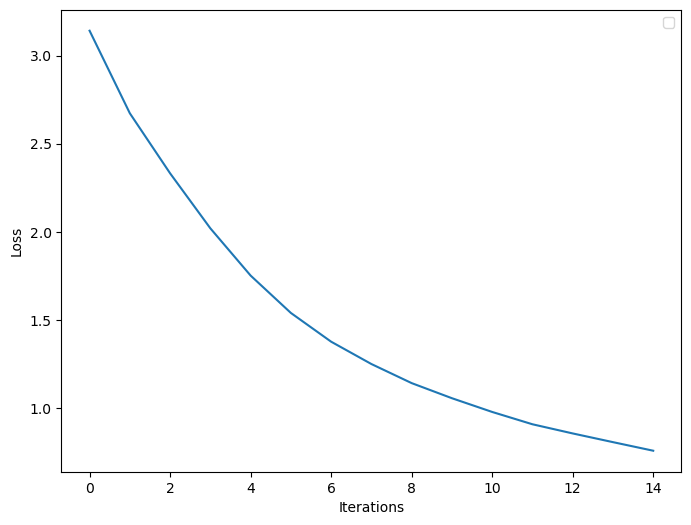

In [9]:
fig = plt.figure(figsize=(8, 6))
plt.plot(model.train_losses)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

## Validation

## Testing

In [10]:
model.saveModel()
#model.test(test_loader)

In [11]:
net = Network().to(device)
net.load_state_dict(torch.load("/kaggle/working/simpsons_model.pth"))

<All keys matched successfully>

In [12]:
net.test(test_loader)

Testing started
Testing finished
F1(torchmetrics): 80.793%


<BarContainer object of 42 artists>

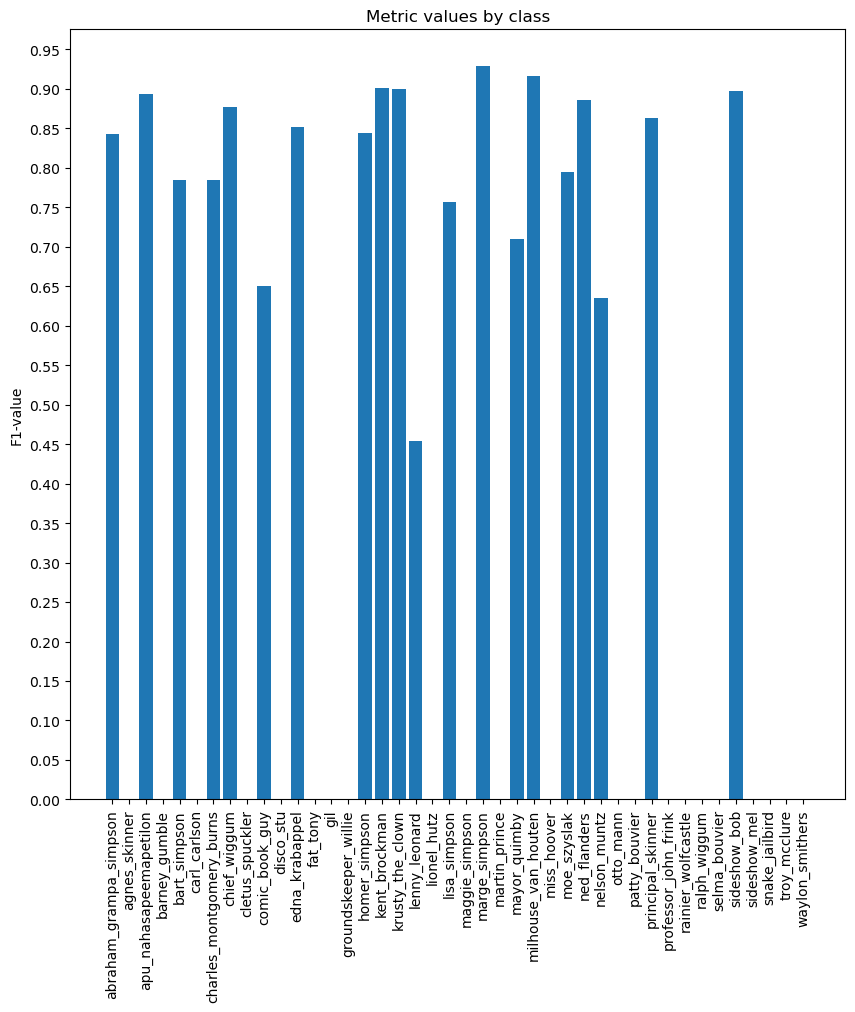

In [13]:
bar = plt.figure(figsize=(10,10))
plt.title("Metric values by class")
plt.ylabel('F1-value')
plt.xticks(rotation=90)
plt.yticks(ticks=np.arange(0, 1.00, 0.05))
plt.bar(class_names, np.array(net.test_accs.cpu()))